In [29]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import json
import random
import os
import hydra
import logging

import torch
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# from pytorch_lightning.plugins import DDPPlugin
from avg_ckpts import ensemble
from datamodule.data_module import DataModule
from datamodule.grid_dataset import GridDataset

In [4]:
from datamodule.transforms import VideoTransform

## Testing Dataset/DataLoader

In [ ]:
from datamodule.grid_dataset import GridDataset
root_dir = "/ssd_scratch/cvit/vanshg/preprocessed_grid/video"
label_path = "/ssd_scratch/cvit/vanshg/preprocessed_grid/labels/s1_label.csv"
data_size = 0.8

dataset = GridDataset(root_dir, label_path, VideoTransform("train"), data_size=data_size)

In [12]:
for data in dataset:
    print(type(data))
    print(data['input'].shape)
    print(data['target'])
    break

<class 'dict'>
torch.Size([75, 1, 88, 88])
tensor([ 941,  969,  811, 2033, 4742, 3291])


In [17]:
from datamodule.phrase_dataset import PhraseDataset
from datamodule.data_module_phrase import pad, collate_pad

def _dataloader(ds, collate_fn):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=5,
        num_workers=1,
        pin_memory=True,
        collate_fn=collate_fn,
    )

root_dir = "/ssd_scratch/cvit/vanshg/vansh_phrases"
label_path = "/ssd_scratch/cvit/vanshg/vansh_phrases/train_labels.txt"
data_size = 1.0

dataset = PhraseDataset(root_dir, label_path, VideoTransform('train'), data_size=data_size)

Label Path : /ssd_scratch/cvit/vanshg/vansh_phrases/train_labels.txt, exists = True
Size of self.video_list: 70


In [18]:
train_dataloader = _dataloader(dataset, collate_pad)

for i, batch in enumerate(train_dataloader):
    if i > 5:
        break
    print(type(batch))
    print(batch.keys())
    print(batch['targets'].shape)
    print(batch['inputs'].shape)
    print(batch['input_lengths'].shape)
    print(batch['target_lengths'].shape)

<class 'dict'>
dict_keys(['inputs', 'input_lengths', 'targets', 'target_lengths'])
torch.Size([5, 1, 8])
torch.Size([5, 70, 1, 88, 88])
torch.Size([5])
torch.Size([5])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2bed6d4400>
Traceback (most recent call last):
  File "/home2/vanshg/miniconda3/envs/lip-reading/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home2/vanshg/miniconda3/envs/lip-reading/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home2/vanshg/miniconda3/envs/lip-reading/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2bed6d4400>
Traceback (most recent call last):
  File "/home2/vanshg/miniconda3/envs/lip-reading/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479

<class 'dict'>
dict_keys(['inputs', 'input_lengths', 'targets', 'target_lengths'])
torch.Size([5, 1, 7])
torch.Size([5, 68, 1, 88, 88])
torch.Size([5])
torch.Size([5])
<class 'dict'>
dict_keys(['inputs', 'input_lengths', 'targets', 'target_lengths'])
torch.Size([5, 1, 7])
torch.Size([5, 67, 1, 88, 88])
torch.Size([5])
torch.Size([5])
<class 'dict'>
dict_keys(['inputs', 'input_lengths', 'targets', 'target_lengths'])
torch.Size([5, 1, 8])
torch.Size([5, 66, 1, 88, 88])
torch.Size([5])
torch.Size([5])
<class 'dict'>
dict_keys(['inputs', 'input_lengths', 'targets', 'target_lengths'])
torch.Size([5, 1, 8])
torch.Size([5, 63, 1, 88, 88])
torch.Size([5])
torch.Size([5])
<class 'dict'>
dict_keys(['inputs', 'input_lengths', 'targets', 'target_lengths'])
torch.Size([5, 1, 9])
torch.Size([5, 65, 1, 88, 88])
torch.Size([5])
torch.Size([5])


In [8]:
for data in dataset:
    print(type(data))
    print(data['input'].shape)
    print(data['target'])
    break

<class 'dict'>
torch.Size([1, 53, 88, 88])
tensor([2550, 3231,  544, 2408,  276,  129,  228,  175])


In [9]:
label_path = "/ssd_scratch/cvit/vanshg/vansh_phrases/phrases.json"
dst_train_label_path = "/ssd_scratch/cvit/vanshg/vansh_phrases/train_phrases_60.json"
dst_test_label_path = "/ssd_scratch/cvit/vanshg/vansh_phrases/test_phrases_40.json"

f = open(label_path, 'r')

video_list = json.load(f)
rng = random.Random(69)
rng.shuffle(video_list)

train_video_list = video_list[:60]
test_video_list = video_list[60:]
print(len(train_video_list))
print(len(test_video_list))

with open(dst_train_label_path, 'w') as file:
    json.dump(train_video_list, file)

with open(dst_test_label_path, 'w') as file:
    json.dump(test_video_list, file)

60
40


## Testing inference

In [1]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [1]:
import os
import json
import glob
import csv

import hydra
import cv2
import torch
import torchaudio
import torchvision

from datamodule.av_dataset import cut_or_pad
from datamodule.transforms import AudioTransform, VideoTransform
from hydra import initialize, compose
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
class InferencePipeline(torch.nn.Module):
    def __init__(self, cfg, detector="retinaface"):
        super(InferencePipeline, self).__init__()
        self.modality = cfg.data.modality
        if self.modality in ["audio", "audiovisual"]:
            self.audio_transform = AudioTransform(subset="test")
        if self.modality in ["video", "audiovisual"]:
            if detector == "mediapipe":
                from preparation.detectors.mediapipe.detector import LandmarksDetector
                from preparation.detectors.mediapipe.video_process import VideoProcess
                self.landmarks_detector = LandmarksDetector()
                self.video_process = VideoProcess(convert_gray=False)
            elif detector == "retinaface":
                from preparation.detectors.retinaface.detector import LandmarksDetector
                from preparation.detectors.retinaface.video_process import VideoProcess
                self.landmarks_detector = LandmarksDetector(device="cuda:0")
                self.video_process = VideoProcess(convert_gray=False)
            self.video_transform = VideoTransform(subset="test")

        if cfg.data.modality in ["audio", "video"]:
            from lightning import ModelModule
        elif cfg.data.modality == "audiovisual":
            from lightning_av import ModelModule
        self.modelmodule = ModelModule(cfg)
        self.modelmodule.model.load_state_dict(torch.load(cfg.pretrained_model_path, map_location=lambda storage, loc: storage))
        self.modelmodule.eval()


    def forward(self, data_filename):
        data_filename = os.path.abspath(data_filename)
        assert os.path.isfile(data_filename), f"data_filename: {data_filename} does not exist."

        if self.modality in ["audio", "audiovisual"]:
            audio, sample_rate = self.load_audio(data_filename)
            audio = self.audio_process(audio, sample_rate)
            audio = audio.transpose(1, 0)
            audio = self.audio_transform(audio)

        if self.modality in ["video", "audiovisual"]:
            video = self.load_video(data_filename)
            landmarks = self.landmarks_detector(video)
            video = torch.tensor(self.video_process(video, landmarks)) # (T, H, W, C)
            video = video.permute(0, 3, 1, 2) # (T, C, H, W)
            print(f"video.shape = {video.shape}")
            video = self.video_transform(video)
            print(f"shape of video after transformation: {video.shape}")

            return video
        if self.modality == "video":
            with torch.no_grad():
                self.modelmodule = self.modelmodule.to(device)
                transcript = self.modelmodule(video)
        elif self.modality == "audio":
            with torch.no_grad():
                transcript = self.modelmodule(audio)

        elif self.modality == "audiovisual":
            print(len(audio), len(video))
            assert 530 < len(audio) // len(video) < 670, "The video frame rate should be between 24 and 30 fps."

            rate_ratio = len(audio) // len(video)
            if rate_ratio == 640:
                pass
            else:
                print(f"The ideal video frame rate is set to 25 fps, but the current frame rate ratio, calculated as {len(video)*16000/len(audio):.1f}, which may affect the performance.")
                audio = cut_or_pad(audio, len(video) * 640)
            with torch.no_grad():
                transcript = self.modelmodule(video, audio)

        return transcript

    def load_audio(self, data_filename):
        waveform, sample_rate = torchaudio.load(data_filename, normalize=True)
        return waveform, sample_rate

    def load_video(self, data_filename):
        return torchvision.io.read_video(data_filename, pts_unit="sec")[0].numpy()

    def audio_process(self, waveform, sample_rate, target_sample_rate=16000):
        if sample_rate != target_sample_rate:
            waveform = torchaudio.functional.resample(
                waveform, sample_rate, target_sample_rate
            )
        waveform = torch.mean(waveform, dim=0, keepdim=True)
        return waveform

In [8]:
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="config")
    cfg.data.modality = 'video'
    cfg.pretrained_model_path = "./checkpoints/lrs3/models/LRS3_V_WER19.1/model.pth"
    cfg.file_path = "/home/vanshg/play/IIITH/research-cvit/lip-reading/Visual_Speech_Recognition_for_Multiple_Languages/data/test/0QVXdEOiCw8/00001.mp4"

    pipeline = InferencePipeline(cfg)
    video = pipeline(cfg.file_path)
    print(f"video.shape after transform = {video.shape}")
    print(f"video.min = {video.min()} | video.max = {video.max()}")
    # video = video.to('cpu')
    # print(video.shape, video.device)

    # with open('processed_video1.pkl', 'wb') as file:
    #     torch.save(video, file)

{'decoder': 0.9, 'ctc': 0.1, 'lm': 0.3, 'length_bonus': 0.0}
init: self.device: cpu
video.shape = torch.Size([49, 96, 96, 3])
shape of video after transformation: torch.Size([1, 49, 88, 88])
video.shape after transform = torch.Size([1, 49, 88, 88])
video.min = -2.1237075328826904 | video.max = 1.7740938663482666


In [9]:
with open('processed_video.pkl', 'rb') as file:
    other_video = torch.load(file)

print(video.shape, video.device, video.dtype)
print(other_video.shape, other_video.device, other_video.dtype)

torch.Size([1, 49, 88, 88]) cpu torch.float32
torch.Size([1, 49, 88, 88]) cpu torch.float32


In [10]:
torch.allclose(video, other_video)

False

In [11]:
with torch.no_grad():
    model = pipeline.modelmodule.to('cuda')
    data = video.to('cuda')
    transcript = model(data)
    print(transcript)

sample.shape = torch.Size([1, 49, 88, 88])
Number of hypothesis: 132
Prediction 0: IT WASN'T REALLY ALL LIKE THIS | scores: {'decoder': -4.883006572723389, 'ctc': -9.339526176452637, 'lm': -27.997802734375}
Prediction 1: IT WASN'T VERY COOL LIKE THIS | scores: {'decoder': -5.048012733459473, 'ctc': -7.849823474884033, 'lm': -29.284236907958984}
Prediction 2: IT WASN'T QUITE ALL LIKE THIS | scores: {'decoder': -6.687277793884277, 'ctc': -11.480616569519043, 'lm': -26.260738372802734}
Prediction 3: IT WASN'T REALLY AT ALL LIKE THIS | scores: {'decoder': -7.503573417663574, 'ctc': -13.569295883178711, 'lm': -25.910791397094727}
Prediction 4: IT WASN'T REALLY QUITE LIKE THIS | scores: {'decoder': -7.709312915802002, 'ctc': -11.921098709106445, 'lm': -26.63516616821289}
Prediction 5: IT WASN'T VERY COOL LOOKING THINGS | scores: {'decoder': -5.334903717041016, 'ctc': -14.818465232849121, 'lm': -35.50229263305664}
Prediction 6: I WASN'T REALLY AT ALL LIKE THIS | scores: {'decoder': -8.1128149

: 

In [6]:
t1 = torch.load('original.pth')
print(t1.shape)

t2 = torch.load('temp.pth')
print(t2.shape)

print(t1)

torch.Size([60, 96, 96, 3])
torch.Size([60, 96, 96, 3])
tensor([[[[118, 103,  94],
          [119, 104,  95],
          [118, 103,  94],
          ...,
          [119,  97,  89],
          [122, 100,  92],
          [124, 102,  94]],

         [[119, 104,  95],
          [119, 104,  95],
          [119, 104,  95],
          ...,
          [120,  98,  90],
          [123, 101,  93],
          [124, 102,  94]],

         [[120, 103,  95],
          [120, 103,  95],
          [119, 102,  94],
          ...,
          [122,  99,  88],
          [125, 102,  91],
          [126, 103,  92]],

         ...,

         [[106, 116, 120],
          [113, 123, 127],
          [100, 108, 115],
          ...,
          [ 79,  55,  49],
          [ 78,  53,  50],
          [ 78,  53,  50]],

         [[115, 123, 128],
          [119, 127, 132],
          [110, 115, 123],
          ...,
          [ 79,  55,  49],
          [ 77,  52,  49],
          [ 77,  52,  49]],

         [[107, 115, 120],
       

In [13]:
not_eq = (t1 != t2)
print(t1.numel())
print(not_eq.sum())

1658880
tensor(1441631)


In [12]:
import nltk
from nltk.corpus import cmudict
from collections import defaultdict

cmu_dict = cmudict.dict()

unique_phonemes = defaultdict(int)

for i, (w, p) in enumerate(cmu_dict.items()):
    phoenemes = p[0]
    for ph in phoenemes:
        if len(ph) == 3:
            unique_phonemes[ph[:2]] += 1
        else:
            unique_phonemes[ph] += 1

print(len(unique_phonemes.keys()))
print(unique_phonemes.keys())

39
dict_keys(['AH', 'EY', 'F', 'AO', 'R', 'T', 'UW', 'W', 'N', 'IH', 'P', 'L', 'AA', 'B', 'ER', 'G', 'K', 'S', 'EH', 'TH', 'M', 'D', 'V', 'Z', 'IY', 'AE', 'OW', 'NG', 'SH', 'HH', 'AW', 'AY', 'JH', 'Y', 'CH', 'ZH', 'UH', 'DH', 'OY'])


'playdate' is not in cmu_dict
1 412


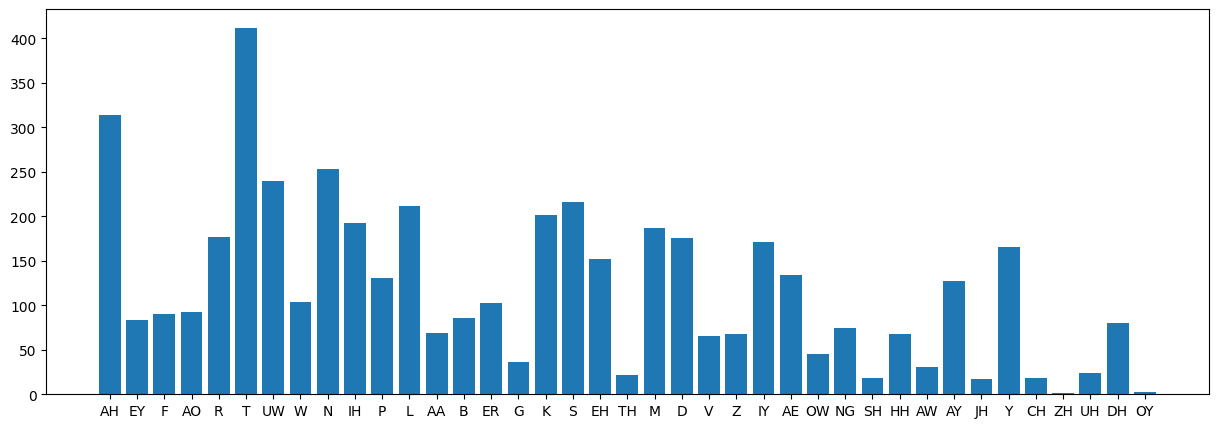

In [37]:
import string
import matplotlib.pyplot as plt

def preprocess_text(text):
    punctuation = string.punctuation.replace("'", "")
    text = text.translate(str.maketrans('', '', punctuation))
    text = text.lower()
    return text

# dictionary for storing the phoneme frequencies
phoeneme_freq = dict()
for ph in unique_phonemes.keys():
    phoeneme_freq[ph] = 0

sentences = open('./vocabs/claude-sentences.txt').readlines()
for sentence in sentences:
    text = preprocess_text(sentence).split()
    for word in text:
        if word in cmu_dict.keys():
            p = cmu_dict[word][0]
            for ph in p:
                if len(ph) == 3:
                    phoeneme_freq[ph[:2]] += 1
                else:
                    phoeneme_freq[ph] += 1
        else:
            print(f"'{word}' is not in cmu_dict")

freq = phoeneme_freq.values()
print(min(freq), max(freq))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(phoeneme_freq.keys(), phoeneme_freq.values())
plt.show()

In [ ]:
import string
import matplotlib.pyplot as plt

def preprocess_text(text):
    punctuation = string.punctuation.replace("'", "")
    text = text.translate(str.maketrans('', '', punctuation))
    text = text.lower()
    return text

# dictionary for storing the phoneme frequencies
phoeneme_freq = dict()
for ph in unique_phonemes.keys():
    phoeneme_freq[ph] = 0

sentences = open('./vocabs/test-sentences-gpt.txt').readlines()
for sentence in sentences:
    text = preprocess_text(sentence).split()
    for word in text:
        if word in cmu_dict.keys():
            p = cmu_dict[word][0]
            for ph in p:
                if len(ph) == 3:
                    phoeneme_freq[ph[:2]] += 1
                else:
                    phoeneme_freq[ph] += 1
        else:
            print(f"'{word}' is not in cmu_dict")

freq = phoeneme_freq.values()
print(min(freq), max(freq))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(phoeneme_freq.keys(), phoeneme_freq.values())
plt.show()

## Testing Preprocessing

In [30]:
import os
import json
import glob
import csv

import cv2
import numpy as np
import hydra
import torch
import torchaudio
import torchvision
import copy
import matplotlib.pyplot as plt

from datamodule.av_dataset import cut_or_pad
from datamodule.transforms import AudioTransform, VideoTransform


In [31]:
from preparation.detectors.retinaface.detector import LandmarksDetector
from preparation.detectors.retinaface.video_process import VideoProcess

landmarks_detector = LandmarksDetector(device='cuda:0')
video_process = VideoProcess(convert_gray=False)

In [6]:
def load_video(data_filename):
    return torchvision.io.read_video(data_filename, pts_unit="sec")[0].numpy()

In [7]:
vid_filename = "./data/cut-0.mp4"
video = load_video(vid_filename)
print(video.shape)

(768, 360, 640, 3)


In [14]:
landmarks = landmarks_detector(video)

In [35]:
processed_landmarks = video_process.interpolate_landmarks(landmarks)

transformed_frame = video_process.crop_patch(video, processed_landmarks)
print(transformed_frame.shape)

(768, 256, 256, 3)


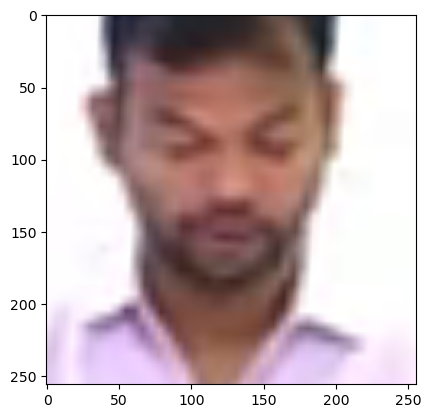

In [41]:
plt.imshow(transformed_frame[400])

## Testing Model Freezing

In [1]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [24]:
import os
import json
import glob
import csv

import hydra
import cv2
import torch
import torchaudio
import torchvision

from datamodule.av_dataset import cut_or_pad
from datamodule.transforms import AudioTransform, VideoTransform
from hydra import initialize, compose
from utils.finetune_utils import *
import matplotlib.pyplot as plt
from lightning_grid import ModelModule

from datamodule.transforms import TextTransform
from espnet.nets.pytorch_backend.e2e_asr_transformer import E2E

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="config")
    cfg.data.modality = 'video'
    cfg.pretrained_model_path = "./checkpoints/lrs3/models/LRS3_V_WER19.1/model.pth"

print(type(cfg))

<class 'omegaconf.dictconfig.DictConfig'>


In [8]:
text_transform = TextTransform()
token_list = text_transform.token_list
backbone_args = cfg.model.visual_backbone

model = E2E(len(token_list), backbone_args)

In [9]:
print(model)

E2E(
  (encoder): Encoder(
    (frontend): Conv3dResNet(
      (trunk): ResNet(
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): Swish()
            (relu2): Swish()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): Swish()
            (relu2): Swish()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn

In [23]:
print(model.ctc)

CTC(
  (ctc_lo): Linear(in_features=768, out_features=5049, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (ctc_loss): CTCLoss()
)


In [48]:
freeze_decoder(model)
freeze_ctc(model)
for (name, param) in model.named_parameters():
    if param.requires_grad == True:
        print(name, param.requires_grad)

encoder.frontend.trunk.layer1.0.conv1.weight True
encoder.frontend.trunk.layer1.0.bn1.weight True
encoder.frontend.trunk.layer1.0.bn1.bias True
encoder.frontend.trunk.layer1.0.conv2.weight True
encoder.frontend.trunk.layer1.0.bn2.weight True
encoder.frontend.trunk.layer1.0.bn2.bias True
encoder.frontend.trunk.layer1.1.conv1.weight True
encoder.frontend.trunk.layer1.1.bn1.weight True
encoder.frontend.trunk.layer1.1.bn1.bias True
encoder.frontend.trunk.layer1.1.conv2.weight True
encoder.frontend.trunk.layer1.1.bn2.weight True
encoder.frontend.trunk.layer1.1.bn2.bias True
encoder.frontend.trunk.layer2.0.conv1.weight True
encoder.frontend.trunk.layer2.0.bn1.weight True
encoder.frontend.trunk.layer2.0.bn1.bias True
encoder.frontend.trunk.layer2.0.conv2.weight True
encoder.frontend.trunk.layer2.0.bn2.weight True
encoder.frontend.trunk.layer2.0.bn2.bias True
encoder.frontend.trunk.layer2.0.downsample.0.weight True
encoder.frontend.trunk.layer2.0.downsample.1.weight True
encoder.frontend.trunk